# StyleGAN

**Credits**: 

The code is based on [github_1](https://github.com/davidsosa/GANs) and [github_2](https://github.com/rosinality/style-based-gan-pytorch)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

if torch.cuda.is_available():
    DEVICE = 'cuda'
    GPU_DEVICE = 3
    torch.cuda.set_device(GPU_DEVICE)
else:
    DEVICE='cpu'
DEVICE='cpu'

import warnings
warnings.filterwarnings('ignore')

def reset_seed():
    OUTPUT_SEED = 0xBADBEEF
    torch.manual_seed(OUTPUT_SEED)
    np.random.seed(OUTPUT_SEED)

reset_seed()

In [4]:
def show_tensor_images(image_tensor, num_images=16, size=(3, 64, 64), nrow=3):
    '''
    Function for visualizing images: Given a tensor of images, number of images,
    size per image, and images per row, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu().clamp_(0, 1)
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow, padding=0)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.axis('off')
    plt.show()

## 1. Mapping Network

In [5]:
class MappingLayers(nn.Module):
    
    '''
    Mapping Layers Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        hidden_dim: the inner dimension, a scalar
        w_dim: the dimension of the intermediate noise vector, a scalar
    '''
 
    def __init__(self, z_dim, hidden_dim, w_dim):
        super().__init__()
        self.mapping = nn.Sequential(
            # A neural network which takes in tensors of 
            # shape (n_samples, z_dim) and outputs (n_samples, w_dim)
            # with a hidden layer with hidden_dim neurons
            nn.Linear(z_dim,hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim,hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, w_dim)
        )

    def forward(self, noise):
        '''
        Function for completing a forward pass of MappingLayers: 
        Given an initial noise tensor, returns the intermediate noise tensor.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return self.mapping(noise)

## 2. Truncation trick

In [11]:
from scipy.stats import truncnorm
def get_truncated_noise(n_samples, z_dim, truncation):
    '''
    Function for creating truncated noise vectors: Given the dimensions (n_samples, z_dim)
    and truncation value, creates a tensor of that shape filled with random
    numbers from the truncated normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        truncation: the truncation value, a non-negative scalar
    '''
    truncated_noise = truncnorm.rvs(-1*truncation, truncation, size=(n_samples, z_dim))
    return torch.Tensor(truncated_noise)

def scale_w(w, w_mean=None, w_weight=None):
    if w_mean is not None:
        w = w_mean + w_weight * (w - w_mean)
    return w

## 3. Injection Noise

In [7]:
class InjectNoise(nn.Module):
    '''
    Inject Noise Class
    Values:
        channels: the number of channels the image has, a scalar
    '''
    def __init__(self, channels):

        super().__init__()
        self.weight = nn.Parameter( # You use nn.Parameter so that these weights can be optimized
            # Initiate the weights for the channels from a random normal distribution
            torch.randn(channels)[None, :, None, None] #torch.randn((1,channels,1,1))
        )

    def forward(self, image):
        '''
        Function for completing a forward pass of InjectNoise: Given an image, 
        returns the image with random noise added.
        Parameters:
            image: the feature map of shape (n_samples, channels, width, height)
        '''
        # Set the appropriate shape for the noise!

        noise_shape = (image.shape[0], 1, image.shape[2], image.shape[3])

        noise = torch.randn(noise_shape, device=image.device) # Creates the random noise
        return image + self.weight * noise # Applies to image after multiplying by the weight for each channel


## 4. Adaptive Normalization

In [17]:
# Adaptive Instance Norm
class AdaIN(nn.Module):
    '''
    AdaIN Class
    Values:
        channels: the number of channels the image has, a scalar
        w_dim: the dimension of the intermediate noise vector, a scalar
    '''

    def __init__(self, channels, w_dim):
        super().__init__()

        # Normalize the input per-channels
        self.instance_norm = nn.InstanceNorm2d(channels)

        # You want to map w to a set of style weights per channel.
        # Replace the Nones with the correct dimensions - keep in mind that 
        # both linear maps transform a w vector into style weights 
        # corresponding to the number of image channels.
        self.style_scale_transform = nn.Linear(w_dim, channels)
        self.style_shift_transform = nn.Linear(w_dim, channels)

    def forward(self, image, w):
        '''
        Function for completing a forward pass of AdaIN: Given an image and intermediate noise vector w, 
        returns the normalized image that has been scaled and shifted by the style.
        Parameters:
            image: the feature map of shape (n_samples, channels, width, height)
            w: the intermediate noise vector w
        '''
        normalized_image = self.instance_norm(image)
        style_scale = self.style_scale_transform(w)[:, :, None, None]
        style_shift = self.style_shift_transform(w)[:, :, None, None]

        # Calculate the transformed image
        transformed_image = style_scale * normalized_image + style_shift
        return transformed_image

## 5. Progressive GAN

In [40]:
# UNQ_C5 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED CELL: MicroStyleGANGeneratorBlock

class MicroStyleGANGeneratorBlock(nn.Module):
    '''
    Micro StyleGAN Generator Block Class
    Values:
        in_chan: the number of channels in the input, a scalar
        out_chan: the number of channels wanted in the output, a scalar
        w_dim: the dimension of the intermediate noise vector, a scalar
        kernel_size: the size of the convolving kernel
        starting_size: the size of the starting image
    '''

    def __init__(
        self, 
        in_chan, 
        out_chan, 
        w_dim, 
        kernel_size, 
        starting_size, 
        use_upsample=True):

        super().__init__()
        self.use_upsample = use_upsample

        if self.use_upsample:
            self.upsample = nn.Upsample(starting_size, mode='bilinear')
        self.conv = nn.Conv2d(in_chan, out_chan, kernel_size, padding=kernel_size // 2) # Padding is used to maintain the image size
        self.inject_noise = InjectNoise(out_chan)
        self.adain = AdaIN(out_chan, w_dim)
        self.activation = nn.LeakyReLU(0.2)

    def forward(self, x, w):
        '''
        Function for completing a forward pass of MicroStyleGANGeneratorBlock: Given an x and w, 
        computes a StyleGAN generator block.
        Parameters:
            x: the input into the generator, feature map of shape (n_samples, channels, width, height)
            w: the intermediate noise vector
        '''
        if self.use_upsample:
            x = self.upsample(x)
        x = self.conv(x)
        x = self.inject_noise(x)
        x = self.activation(x)
        x = self.adain(x, w)
        return x

class StyledSequential(nn.Sequential):

    def forward(self, x, w):
        for module in self._modules.values():
            x = module(x, w)
        return x

In [41]:
class MicroStyleGANGenerator(nn.Module):
    '''
    Micro StyleGAN Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        map_hidden_dim: the mapping inner dimension, a scalar
        w_dim: the dimension of the intermediate noise vector, a scalar
        in_chan: the dimension of the constant input, usually w_dim, a scalar
        out_chan: the number of channels wanted in the output, a scalar
        kernel_size: the size of the convolving kernel
        hidden_chan: the inner dimension, a scalar
    '''

    def __init__(self, 
                 z_dim, # z dimensionality
                 map_hidden_dim, # mapping network parameter
                 w_dim, # style vector dimensionality
                 in_chan, # number of channels in input trainable tensor
                 out_chan, # images dimensionality
                 kernel_size, 
                 hidden_chan):
        super().__init__()
        self.map = MappingLayers(z_dim, map_hidden_dim, w_dim)
        # Typically this constant is initiated to all ones, but you will initiate to a
        # Gaussian to better visualize the network's effect
        self.starting_constant = nn.Parameter(torch.randn(1, in_chan, 4, 4))

        self.progression = nn.ModuleList(
            [
                StyledSequential(*[
                    MicroStyleGANGeneratorBlock(in_chan, hidden_chan, w_dim, kernel_size, 4, use_upsample=False),
                    MicroStyleGANGeneratorBlock(hidden_chan, hidden_chan, w_dim, kernel_size, 4, use_upsample=False)]),
                StyledSequential(*[
                    MicroStyleGANGeneratorBlock(hidden_chan, hidden_chan, w_dim, kernel_size, 8, use_upsample=True),
                    MicroStyleGANGeneratorBlock(hidden_chan, hidden_chan, w_dim, kernel_size, 8, use_upsample=False)]),
                StyledSequential(*[
                    MicroStyleGANGeneratorBlock(hidden_chan, hidden_chan, w_dim, kernel_size, 16, use_upsample=True),
                    MicroStyleGANGeneratorBlock(hidden_chan, hidden_chan, w_dim, kernel_size, 16, use_upsample=False)]),
                StyledSequential(*[
                    MicroStyleGANGeneratorBlock(hidden_chan, hidden_chan, w_dim, kernel_size, 32, use_upsample=True),
                    MicroStyleGANGeneratorBlock(hidden_chan, hidden_chan, w_dim, kernel_size, 32, use_upsample=False)])
            ]
        )

        self.to_rgb = nn.ModuleList(
            [
                nn.Conv2d(hidden_chan, out_chan, kernel_size=1),
                nn.Conv2d(hidden_chan, out_chan, kernel_size=1),
                nn.Conv2d(hidden_chan, out_chan, kernel_size=1),
                nn.Conv2d(hidden_chan, out_chan, kernel_size=1)
            ]
        )

    def forward(self, noise, step=0, alpha=-1, w_mean=None, w_weight=None):
        '''
        Function for completing a forward pass of MicroStyleGANGenerator: Given noise, 
        computes a StyleGAN iteration.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
            return_intermediate: a boolean, true to return the images as well (for testing) and false otherwise
        '''
        x = self.starting_constant
        w = self.map(noise)
        w = scale_w(w, w_mean, w_weight)

        for i, (conv, to_rgb) in enumerate(zip(self.progression, self.to_rgb)):

            if i > 0 and step > 0:
                x_prev = x

            x = conv(x, w)

            if i == step:
                x = to_rgb(x)

                if i > 0 and 0 <= alpha < 1:
                    skip_rgb = self.to_rgb[i - 1](x_prev)
                    skip_rgb = F.interpolate(skip_rgb, scale_factor=2, mode='bilinear')
                    x = (1 - alpha) * skip_rgb + alpha * x

                break

        return x

## 6. Unit tests and visualization

In [55]:
z_dim = 128
out_chan = 3
truncation = 0.7

SG_generator = MicroStyleGANGenerator(
    z_dim=z_dim, 
    map_hidden_dim=256,
    w_dim=64,
    in_chan=64,
    out_chan=out_chan, 
    kernel_size=3, 
    hidden_chan=32
)

test_samples = 10
test_result = SG_generator(get_truncated_noise(test_samples, z_dim, truncation), step=3)

# Check if the block works
assert tuple(test_result.shape) == (test_samples, out_chan, 32, 32)

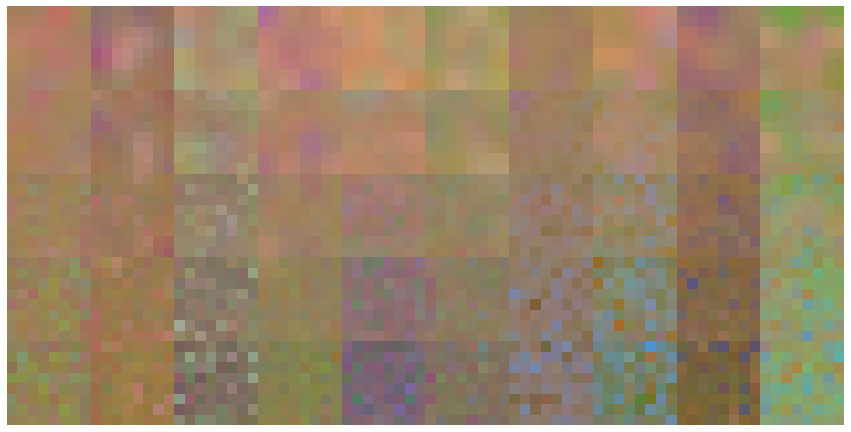

In [57]:
import numpy as np
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 15]

viz_samples = 10
# The noise is exaggerated for visual effect
viz_noise = get_truncated_noise(viz_samples, z_dim, truncation) * 10

SG_generator.eval()
images = []
for alpha in np.linspace(0, 1, num=5):
    viz_result =  SG_generator(viz_noise, step=1, alpha=alpha)
    images += [tensor for tensor in viz_result]
show_tensor_images(torch.stack(images), nrow=viz_samples, num_images=len(images))
SG_generator = SG_generator.train()

## Discriminator

In [61]:
class ConvBlock(nn.Module):

    def __init__(
        self,
        in_channel,
        out_channel,
        kernel_size,
        downsample=False,
    ):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size, padding=kernel_size//2),
            nn.LeakyReLU(0.2),
        )

        if downsample:
            self.conv2 = nn.Sequential(
                nn.Conv2d(out_channel, out_channel, kernel_size, padding=kernel_size//2),
                nn.AvgPool2d(2),
                nn.LeakyReLU(0.2),
            )

        else:
            self.conv2 = nn.Sequential(
                nn.Conv2d(out_channel, out_channel, kernel_size, padding=kernel_size//2),
                nn.LeakyReLU(0.2),
            )

    def forward(self, input):
        out = self.conv1(input)
        out = self.conv2(out)

        return out

class Discriminator(nn.Module):

    def __init__(
        self, 
        in_chan,
        out_chan, 
        kernel_size, 
        hidden_chan):

        super().__init__()

        self.progression = nn.ModuleList(
            [
                ConvBlock(hidden_chan, hidden_chan, kernel_size, downsample=True), # 16
                ConvBlock(hidden_chan, hidden_chan, kernel_size, downsample=True), # 8
                ConvBlock(hidden_chan, hidden_chan, kernel_size, downsample=True), # 4
                nn.Sequential(*[
                    nn.Conv2d(hidden_chan, hidden_chan, kernel_size, padding=kernel_size//2),
                    nn.LeakyReLU(0.2),
                    nn.Conv2d(hidden_chan, in_chan, 4, padding=0),
                    nn.LeakyReLU(0.2)])
            ]
        )

        self.from_rgb = nn.ModuleList(
            [
                nn.Conv2d(out_chan, hidden_chan, kernel_size=1),
                nn.Conv2d(out_chan, hidden_chan, kernel_size=1),
                nn.Conv2d(out_chan, hidden_chan, kernel_size=1),
                nn.Conv2d(out_chan, hidden_chan, kernel_size=1)
            ]
        )

        self.n_layer = len(self.progression)

        self.linear = nn.Linear(in_chan, 1)

    def forward(self, input, step=0, alpha=-1):
        out = self.from_rgb[self.n_layer - step - 1](input)
        out = self.progression[self.n_layer - step - 1](out)

        if step > 0 and  0 <= alpha < 1:
            skip_rgb = F.avg_pool2d(input, 2)
            skip_rgb = self.from_rgb[self.n_layer - step](skip_rgb)
            out = (1 - alpha) * skip_rgb + alpha * out

        for i in range(step - 1, -1, -1):
            index = self.n_layer - i - 1
            out = self.progression[index](out)

        out = out.squeeze(2).squeeze(2)
        # print(input.size(), out.size(), step)
        out = self.linear(out)

        return out

In [62]:
SG_discriminator = Discriminator(
    in_chan=64,
    out_chan=out_chan, 
    kernel_size=3, 
    hidden_chan=32
)

In [68]:
viz_result =  SG_generator(viz_noise, step=2, alpha=0.5)

In [69]:
viz_result.shape

torch.Size([10, 3, 16, 16])

In [70]:
discr_results = SG_discriminator(viz_result, step=2, alpha=0.5)

In [71]:
discr_results.shape

torch.Size([10, 1])